# Minimax Depth vs Move-Time Analysis
In this notebook, we explore the relationship between the **depth** parameter of the Minimax algorithm and the corresponding **move-time** during gameplay in Othello. Essentially, we must understand the time it takes for our AI to make moves. The core hypothesis is based on the theoretical understanding that the complexity of the Minimax algorithm, particularly in terms of search time, grows *exponentially* with depth, i.e. $\mathcal{O}(b^d)$, where $b$ is the breadth of the game tree and $d$ is the depth. Here, "move-time" essentially refers to the time taken for a complete search cycle at a given depth. Through systematic data collection and analysis from Othello matches using Minimax agents, we aim to empirically validate the theoretically anticipated exponential growth pattern of move-time with increasing depth.

---

## Theoretical Analysis
The theoretical analysis aims to develop an understanding of how the Minimax algorithm's move-time (incorporating the search time) scales with varying depths in the game of Othello, focusing on the hypothesized relationship $f(d) = T \cdot b^d$, where $f(d)$ denotes the move-time at depth $d$.


- **Hypothesized Relationship:** Let $f(d)$ be the move-time for the Minimax algorithm at depth $d$. The Minimax algorithm's time complexity as a function of depth is expected to follow: $f(d) = T \cdot b^d$, where $T$ represents the average time taken to evaluate a single node in the search tree, and $b$ is the branching factor (approximately $b=10$ for Othello [1]). The key aspect of this relationship is its expected exponential nature.

- **Parameter Estimation:** To explore this hypothesized relationship, we plan to analyse $f(d)$ at depth 1 to establish a baseline: $f(1) = T \cdot b$. With the hypothesized relationship and reported branching factor from the literature ($b = 10$), we aim to estimate $T$.

- **Validation:** Post estimation, empirical validation will be conducted to compare our theoretical assumptions with observed data. Successful validation will confirm our understanding of how Minimax's move-time scales with depth in Othello.

**References:**

[1] Norvig, P. (1992) '[Search and the Game of Othello](https://www.sciencedirect.com/science/article/abs/pii/B9780080571157500182)', in Paradigms of Artificial Intelligence Programming: Case Studies in Common Lisp, pp. 596-654. doi: 10.1016/B978-0-08-057115-7.50018-2.

---

## Load Source Code

In [1]:
import os
import sys

# Calculate path to the src directory and append to sys.path
current_dir = os.path.dirname(os.path.abspath("Depth_MoveTime_Analysis.ipynb"))
project_root = os.path.dirname(os.path.dirname(current_dir))
sys.path.append(os.path.join(project_root, 'src'))

from game import Game
from board import SquareType
from player import Player, PlayerType
from state_evaluation import StateEvaluator

## Timing Function

- Define the function `logMinimaxMoveTimes_FixedDepth` to record times taken for the Minimax player to make each move.

In [2]:
import time

def logMinimaxMoveTimes_FixedDepth(depth):
    """
    Simulates a single game of Othello between a Minimax player, operating at a 
    specified depth, and a Random player. Records the time taken by the Minimax 
    player to make each move.

    Args:
        depth (int): The depth to which the Minimax algorithm will search. This 
                     parameter directly affects the complexity and performance 
                     of the Minimax player.

    Returns:
        list: A list of float values, each representing the time taken (seconds) 
              for the Minimax player to make a move. List is in chronological 
              order, corresponding to the sequence of the game's moves.
    """
    
    # Instantiate Player & Game instances
    state_eval = StateEvaluator()
    minimax = Player(PlayerType.MINIMAX, SquareType.BLACK, state_eval, depth)
    random = Player(PlayerType.RANDOM, SquareType.WHITE)
    game = Game(minimax, random)
    
    # List to store move times
    minimax_move_times = []
    while not game.is_finished:
        # Black's turn (i.e. Minimax)
        if game.active == game.player_black:
            start_time = time.time()
            game.get_player_move()
            end_time = time.time()
            
            minimax_move_time = end_time - start_time
            minimax_move_times.append(minimax_move_time)
        else:
            game.get_player_move()
            
        game.make_move()
        game.change_turn()
        game.update_valid_moves()
        game.update_scores()
    
        game.check_finished()

    return minimax_move_times

## Parameter Estimation

- Want to estimate $T$, i.e average time taken to evaluate a single node in the search tree
- Record move-times at depth $d = 1, \quad$ i.e. collect observations and compare to theoretical relationship $f(1) = T \cdot b$, $\quad$ or $\quad T = \frac{f(1)}{b}$.

In [3]:
import numpy as np
from tqdm import tqdm
from IPython.display import display, Math

# Simulate many games for reliability
NUM_GAMES = 20
all_move_times = []

for _ in tqdm(range(NUM_GAMES)):
    # Record move-times at depth d=1
    move_times = logMinimaxMoveTimes_FixedDepth(depth=1)
    all_move_times.extend(move_times)
print("Recorded move-times at depth d=1.")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.35s/it]

Recorded move-times at depth d=1.


- Using the above and reported branching factor ($b \approx 10$), approximate 95% confidence interval for $T$, via. $\bar{T} \pm 2 \cdot \text{SE}_\bar{T}$.
- Here, $\bar{T}$ is stored under `T_bar`, and $\text{SE}_\bar{T}$ is stored under `SE`.

In [5]:
# Define branching factor
b = 10

# Calculate sample mean and std dev of T 
T_bar = np.mean(all_move_times) / b
std_dev = np.std(all_move_times) / b

# Calculate standard error of T_bar
SE = std_dev / np.sqrt(len(all_move_times))

# Display estimate and interval
display(Math(f"\\bar{{T}} \\pm 2 \\cdot \\text{{SE}}_{{\\bar{{T}}}}"))
display(Math(f"= {T_bar:.5f} \\pm {2 * SE:.5f}"))
display(Math(f"= [{T_bar - 2 * SE:.5f}, {T_bar + 2 * SE:.5f}]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

- Essentially, our estimate for $T$ is somewhere between $[\bar{T} - 2 \cdot SE, \bar{T} + 2 \cdot SE]$.
- i.e. **Average time taken to evaluate a single node** is between $[\bar{T} - 2 \cdot SE, \bar{T} + 2 \cdot SE]$, as calculated above.

## Validation

- Empirical validation to compare the theoretical relationship and observed data.
- First, gather another sample of move-times. This time, at different depths.
- Calculate the move-time sample mean at each fixed depth, stored under `move_time_sample_means`.

In [6]:
# Simulate only a few games at each depth
# (Exponential relationship largely increases time-taken at higher depths)
NUM_GAMES = 1 # Adjust/re-run with N=3
d_range = np.arange(1, 5)
all_move_times = {d: [] for d in d_range}

for d in tqdm(d_range):
    for _ in tqdm(range(NUM_GAMES)):
        move_times = logMinimaxMoveTimes_FixedDepth(depth=d)
        all_move_times[d].extend(move_times)

# Calculate sample mean move time for each depth in d_range
move_time_sample_means = {d: np.mean(move_times) for d, move_times in all_move_times.items()}
move_time_sample_means

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [32:42<00:00, 490.64s/it]


{1: 0.12741668224334718,
 2: 0.4453379415696667,
 3: 5.486937861288747,
 4: 57.23166821848962}

In [13]:
# import json

# all_move_times_dict = {str(key): value for key, value in all_move_times.items()}

# # Save the dictionary as a JSON file
# with open("all_move_times_dict.json", "w") as json_file:
#     json.dump(all_move_times_dict, json_file)

- After collection, graphically compare observed data to theoretical relationship.
- Plot theoretical relationship at different depths $d$ using estimated mean for $T$, against the observed data.

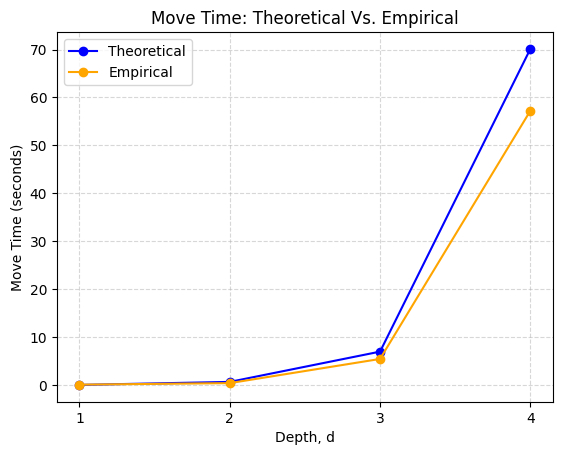

In [24]:
import matplotlib.pyplot as plt

# Depth range and move_time_sample_means dictionary
d_range = np.arange(1, 5)

theoretical_move_times = T_bar * b**d_range
empirical_move_times = list(move_time_sample_means.values())

# Plot the mean value for T (T_bar) against move_time_sample_means
plt.plot(d_range, theoretical_move_times, label='Theoretical', color='blue', marker='o')
plt.plot(d_range, empirical_move_times, label='Empirical', color='orange', marker='o')

plt.xlabel('Depth, d')
plt.ylabel('Move Time (seconds)')
plt.title('Move Time: Theoretical Vs. Empirical')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xticks(d_range)
plt.show()

- Observed data agrees with theorised relationship.
- This confirms our understanding of how Minimax's move-time scales with depth in Othello.
- Additionally, this indicates that $d = 3$ is a suitable depth for users to play against.